In [1]:
from keras import models
from keras import layers
from keras import optimizers
from keras import callbacks
from keras import backend

import numpy as np
import time
from sklearn import datasets
from sklearn import preprocessing
from sklearn import metrics

import theano
import matplotlib.pyplot as plt

import multiprocessing as mp

%matplotlib inline


colors = ['r','b','c','g','k','m','y']
np.set_printoptions(3)

Using Theano backend.


# Load Data

In [2]:
dataset = datasets.load_iris()
data = dataset.data
target = dataset.target

## Select Novelty

In [3]:
novcls = 2
nov_data = data[target==novcls]
nov_target = target[target==novcls]
#
data   = data[target != novcls]
target = target[target != novcls]

## Training Indexes

In [4]:
ntrn = 0.7

indexes = np.arange(data.shape[0])
np.random.shuffle(indexes)
n = int(ntrn * data.shape[0])
itrn = indexes[:n]
itst = indexes[n:]

## Dataprep

In [5]:
scaler = preprocessing.StandardScaler().fit(data[itrn])
data = scaler.transform(data)
nov_data = scaler.transform(nov_data)

# Network Configuration

In [6]:
net_config = {
    'hiddens': [data.shape[1], 10, 5, 2, 5, 10, data.shape[1]],
    'optimizers': ['adam','adam','adam'],
    'nepochs': 500,
    'batch_size': 100,
    'ninit': 10,    
    'nproc' : 2
}

# Network Structure

In [9]:
t0 = time.time()
# Over training layers
npairs = int(len(net_config['hiddens'])/2.0)

nn_trn = {}
nnet   = {}
print('Training %i layer pairs'%npairs)
X = data # input == output
for ilayer in range(1, npairs+1):
    print("\tLayer pair %i"%(ilayer))
    print("\t\tStructure = %i:%i:%i"%(net_config['hiddens'][ilayer-1],
                                      net_config['hiddens'][ilayer],
                                      net_config['hiddens'][len(net_config['hiddens']) - ilayer]))
    print("\t\tActivations = tanh:%s"%('linear' if ilayer == 1 else 'tanh')) # only first iteration's output is linear
    ###### Training
    # Different Initializations
    nn_trn[ilayer] = None
    best_perf = 1e9
    nnet[ilayer] = None
    for iinit in range(net_config['ninit']):
        model = models.Sequential()
        # Create network structure
        model.add(layers.Dense(net_config['hiddens'][ilayer],
                               activation = 'tanh',
                               input_shape = [net_config['hiddens'][ilayer-1]],
                               kernel_initializer = 'uniform'))
        model.add(layers.Dense(net_config['hiddens'][len(net_config['hiddens']) - ilayer],
                               activation = 'linear' if ilayer == 1 else 'tanh',
                               input_shape = [net_config['hiddens'][ilayer]],
                               kernel_initializer = 'uniform'))  
        # Training    
        opt = optimizers.Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
        #opt = optimizers.SGD(lr=0.01, decay=1e-4, momentum=0.9, nesterov=True)
        model.compile(loss='mean_squared_error', optimizer=opt)
        earlyStopping = callbacks.EarlyStopping(monitor='val_loss', patience=100, verbose=0, mode='auto')
        # Should be done for each initialization
        init_trn_desc = model.fit(X[itrn], X[itrn], 
                                  epochs = net_config['nepochs'], 
                                  batch_size = net_config['batch_size'],
                                  callbacks = [earlyStopping], 
                                  verbose = 0,
                                  validation_data = (X[itst], X[itst]),
                                  shuffle=False)
        # Get best
        if init_trn_desc.history['loss'][-1] < best_perf:
            nn_trn[ilayer] = init_trn_desc
            best_perf = init_trn_desc.history['loss'][-1]
            nnet[ilayer] = model

    # Update input as the output of the hidden layer
    hidden_layer = backend.function([nnet[ilayer].layers[0].input],[nnet[ilayer].layers[0].output])
    X = hidden_layer([X])[0]
# Put together final model
final_model = models.Sequential()
final_model.add(nnet[1].layers[0])
final_model.add(nnet[2].layers[0])
final_model.add(nnet[3].layers[0])
final_model.add(nnet[3].layers[1])
final_model.add(nnet[2].layers[1])
final_model.add(nnet[1].layers[1])
# Encoder model
encoder = models.Sequential()
encoder.add(nnet[1].layers[0])
encoder.add(nnet[2].layers[0])
encoder.add(nnet[3].layers[0])

print('Training took %i s'%(time.time() - t0))

Training 3 layer pairs
	Layer pair 1
		Structure = 4:10:4
		Activations = tanh:linear
	Layer pair 2
		Structure = 10:5:10
		Activations = tanh:tanh
	Layer pair 3
		Structure = 5:2:5
		Activations = tanh:tanh
Training took 28 s


0.0132755730301


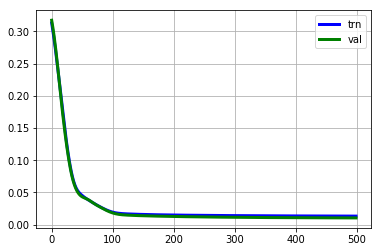

In [10]:
ilayer = 3
metric = 'loss'
plt.plot(nn_trn[ilayer].epoch, nn_trn[ilayer].history[metric], '-b', lw = 3, label='trn')
plt.plot(nn_trn[ilayer].epoch, nn_trn[ilayer].history['val_'+metric], '-g', lw = 3, label='val')
plt.legend(loc='best')
plt.grid()
print(nn_trn[ilayer].history['loss'][-1])

In [11]:
final_model = models.Sequential()

final_model.add(nnet[1].layers[0])
final_model.add(nnet[2].layers[0])
final_model.add(nnet[3].layers[0])
final_model.add(nnet[3].layers[1])
final_model.add(nnet[2].layers[1])
final_model.add(nnet[1].layers[1])

Y = final_model.predict(data)

encoder = models.Sequential()
encoder.add(nnet[1].layers[0])
encoder.add(nnet[2].layers[0])
encoder.add(nnet[3].layers[0])

Z = encoder.predict(data)

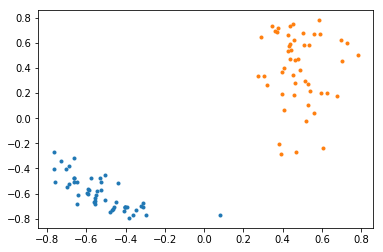

In [12]:
for c in np.unique(target):
    idx = target == c
    plt.plot(Z[idx,0],Z[idx,1],'.')

In [13]:
known_error = metrics.mean_squared_error(Y[itrn], data[itrn])

Ynov = final_model.predict(nov_data)
nov_error = metrics.mean_squared_error(Ynov, nov_data)

print('Expected error: %.3f'%known_error)
print('Novelty  error: %.3f'%nov_error)
print('\tPerc.: %.2f%%'%(100 * (known_error - nov_error)/known_error))


Expected error: 0.053
Novelty  error: 0.519
	Perc.: -876.35%


# Multiprocessing Training 

In [ ]:
def training_parallel(args):
    X = args['data']
    itrn = args['itrn']
    itst = args['itst']
    model = models.Sequential()
    nhidden = args['nhidden']
    ninput = args['ninput']
    noutput = args['noutput']
    act_hidden = args['act_hidden']
    act_output = args['act_output']
    nepochs = args['nepochs']
    batch_size = args['batch_size']
    # Create network structure
    model.add(layers.Dense(nhidden,
                           activation = act_hidden,
                           input_shape = [ninput],
                           kernel_initializer = 'uniform'))
    model.add(layers.Dense(noutput,
                           activation = act_output,
                           input_shape = [nhidden],
                           kernel_initializer = 'uniform'))  
    # Training    
    opt = optimizers.Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    model.compile(loss='mean_squared_error', optimizer=opt)
    earlyStopping = callbacks.EarlyStopping(monitor='val_loss', patience=100, verbose=0, mode='auto')
    # Should be done for each initialization
    init_trn_desc = model.fit(X[itrn], X[itrn], 
                              epochs = nepochs, 
                              batch_size = batch_size,
                              callbacks = [earlyStopping], 
                              verbose = 0,
                              validation_data = (X[itst], X[itst]),
                              shuffle=False)
    return (model, init_trn_desc, init_trn_desc.history['loss'][-1])

In [ ]:
t0 = time.time()

# Over training layers
npairs = int(len(net_config['hiddens'])/2.0)

nn_trn = {}
nnet   = {}
print('Training %i layer pairs'%npairs)
X = data # input == output
for ilayer in range(1, npairs+1):
    print("\tLayer pair %i"%(ilayer))
    print("\t\tStructure = %i:%i:%i"%(net_config['hiddens'][ilayer-1],
                                      net_config['hiddens'][ilayer],
                                      net_config['hiddens'][len(net_config['hiddens']) - ilayer]))
    print("\t\tActivations = tanh:%s"%('linear' if ilayer == 1 else 'tanh')) # only first iteration's output is linear
    ###### Training
    # Different Initializations
    nn_trn[ilayer] = None
    best_perf = 1e9
    nnet[ilayer] = None
    args = {
        'data': X,
        'itrn': itrn,
        'itst': itst,
        'nhidden': net_config['hiddens'][ilayer],
        'ninput': net_config['hiddens'][ilayer-1],
        'noutput': net_config['hiddens'][len(net_config['hiddens']) - ilayer],
        'act_hidden': 'tanh',
        'act_output': 'linear' if ilayer == 1 else 'tanh',
        'nepochs': net_config['nepochs'],
        'batch_size': net_config['batch_size']
        
    }
    
    
    pool = mp.Pool(processes=net_config['nproc'])
    results = [pool.apply_async(training_parallel, args=(args,)) for i in range(net_config['ninit'])]
    results = [p.get() for p in results]
    scores  = [obj[2] for obj in results]
    idx = np.argmin(scores)
    nnet[ilayer]   = results[idx][0]
    nn_trn[ilayer] = results[idx][1]
    # Update input as the output of the hidden layer
    hidden_layer = backend.function([nnet[ilayer].layers[0].input],[nnet[ilayer].layers[0].output])
    X = hidden_layer([X])[0]
# Put together final model
final_model = models.Sequential()
final_model.add(nnet[1].layers[0])
final_model.add(nnet[2].layers[0])
final_model.add(nnet[3].layers[0])
final_model.add(nnet[3].layers[1])
final_model.add(nnet[2].layers[1])
final_model.add(nnet[1].layers[1])
# Encoder model
encoder = models.Sequential()
encoder.add(nnet[1].layers[0])
encoder.add(nnet[2].layers[0])
encoder.add(nnet[3].layers[0])


print('Training took %i s'%(time.time() - t0))

In [ ]:
# Over training layers
npairs = int(len(net_config['hiddens'])/2.0)

nn_trn = {}
nnet   = {}
print('Training %i layer pairs'%npairs)
X = data # input == output
for ilayer in range(1, npairs+1):
    print("\tLayer pair %i"%(ilayer))
    print("\t\tStructure = %i:%i:%i"%(net_config['hiddens'][ilayer-1],
                                      net_config['hiddens'][ilayer],
                                      net_config['hiddens'][len(net_config['hiddens']) - ilayer]))
    print("\t\tActivations = tanh:%s"%('linear' if ilayer == 1 else 'tanh')) # only first iteration's output is linear
    ###### Training
    # Different Initializations
    nn_trn[ilayer] = None
    best_perf = 1e9
    nnet[ilayer] = None
    for iinit in range(net_config['ninit']):
        model = models.Sequential()
        # Create network structure
        model.add(layers.Dense(net_config['hiddens'][ilayer],
                               activation = 'tanh',
                               input_shape = [net_config['hiddens'][ilayer-1]],
                               kernel_initializer = 'uniform'))
        model.add(layers.Dense(net_config['hiddens'][len(net_config['hiddens']) - ilayer],
                               activation = 'linear' if ilayer == 1 else 'tanh',
                               input_shape = [net_config['hiddens'][ilayer-1]],
                               kernel_initializer = 'uniform'))  
        # Training    
        opt = optimizers.Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
        #opt = optimizers.SGD(lr=0.01, decay=1e-4, momentum=0.9, nesterov=True)
        model.compile(loss='mean_squared_error', optimizer=opt)
        earlyStopping = callbacks.EarlyStopping(monitor='val_loss', patience=100, verbose=0, mode='auto')
        # Should be done for each initialization
        init_trn_desc = model.fit(X[itrn], X[itrn], 
                                  epochs = net_config['nepochs'], 
                                  batch_size = net_config['batch_size'],
                                  callbacks = [earlyStopping], 
                                  verbose = 0,
                                  validation_data = (X[itst], X[itst]),
                                  shuffle=False)
        # Get best
        if init_trn_desc.history['loss'][-1] < best_perf:
            nn_trn[ilayer] = init_trn_desc
            best_perf = init_trn_desc.history['loss'][-1]
            nnet[ilayer] = model

    # Update input as the output of the hidden layer
    hidden_layer = backend.function([nnet[ilayer].layers[0].input],[nnet[ilayer].layers[0].output])
    X = hidden_layer([X])[0]
# Put together final model
final_model = models.Sequential()
final_model.add(nnet[1].layers[0])
final_model.add(nnet[2].layers[0])
final_model.add(nnet[3].layers[0])
final_model.add(nnet[3].layers[1])
final_model.add(nnet[2].layers[1])
final_model.add(nnet[1].layers[1])
# Encoder model
encoder = models.Sequential()
encoder.add(nnet[1].layers[0])
encoder.add(nnet[2].layers[0])
encoder.add(nnet[3].layers[0])